Variational message passing demo
===

ForneyLab comes with support for variational message passing (VMP) (Dauwels, 2007). In this demo we illustrate VMP by estimating the mean and precision (inverse variance) of i.i.d. samples drawn from a Gaussian distribution. The model is easily defined as 
\begin{align*}
    y_i \sim \mathcal{N}(m, w^{-1})
\end{align*}
The factor graph below shows our generative model.

```
-------------> = ---> (w)
               | 
---> = --------|----> (m)
     |         |
     ---> N <---
          | 
        (y_i)
```

Variational inference approximates the posterior over $m$ and $w$ by a recognition distribution. We minimize the KL divergence between the exact posterior and the recognition distribution by variational message passing. 

In [2]:
using(ForneyLab)
using PyPlot

n = 5

g = FactorGraph()

# Priors
m ~ GaussianMeanVariance(constant(0.0), constant(100.0))
w ~ Gamma(constant(0.01), constant(0.01))

# Observarion model
for i = 1:n
    y_i ~ GaussianMeanPrecision(m, w)
    placeholder(y_i, :y, index=i)
end

# Assign id for ease of lookup
m.id = :m
w.id = :w
;

With the model defined, we can now specify the recognition factorization, generate a schedule for each recognition factor.

In [3]:
# Specify recognition factorization
q_m = RecognitionFactor(m)
q_w = RecognitionFactor(w)

# Generate schedules
schedule_q_m = variationalSchedule(q_m)
schedule_q_w = variationalSchedule(q_w)
;

We can inspect a subgraph and the generated schedule

In [4]:
ForneyLab.draw(q_m, schedule=schedule_q_m)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 18184290200341974736 -->
 18184290200341974736 
 
 𝒩 
 gaussian_6 
 
<!-- 14852609594711472785 -->
 14852609594711472785 
 
 = 
 equ_variable_1_1 
 
<!-- 16177267780821590349 -->
 16177267780821590349 
 
 𝒩 
 gaussian_2 
 
<!-- 14852609594711472785--16177267780821590349 -->
 14852609594711472785--16177267780821590349 
 
 1 m 
 ((9)) 
 2 2 
 
<!-- 14802567107371125172 -->
 14802567107371125172 
 
 𝒩 
 gaussian_1 
 
<!-- 14852609594711472785--14802567107371125172 -->
 14852609594711472785--14802567107371125172 
 
 3 out 
 ((1)) 
 1 1 
 (10) 
 
<!-- 6110305568455473996 -->
 6110305568455473996 
 
 = 
 equ_variable_1_4 
 
<!-- 6110305568455473996--18184290200341974736 -->
 6110305568455473996--18184290200341974736 
 
 1 m 
 ((3)) 
 3 3 
 
<!-- 3735492515155359337 -->
 3735492515155359337 
 
 = 
 equ_variable_1_3 
 
<!-- 6110305568455473996--3735492515155359337 -->
 6110305568455473996--3735492515155359337 
 
 3 3 
 2 2 
 (4) 
 
<!-- 16784506550573475640 -->
 16784506550573475640 
 
 𝒩 
 gaussian_5 
 
<!-- 6110305568455473996--16784506550573475640 -->
 6110305568455473996--16784506550573475640 
 
 1 m 
 ((2)) 
 1 1 
 
<!-- 2878005504358799848 -->
 2878005504358799848 
 
 𝒩 
 gaussian_3 
 
<!-- 17653162434627864237 -->
 17653162434627864237 
 
 = 
 equ_variable_1_2 
 
<!-- 17653162434627864237--14852609594711472785 -->
 17653162434627864237--14852609594711472785 
 
 3 3 
 2 2 
 (8) 
 
<!-- 17653162434627864237--2878005504358799848 -->
 17653162434627864237--2878005504358799848 
 
 1 m 
 ((7)) 
 1 1 
 
<!-- 14454877173887945630 -->
 14454877173887945630 
 
 𝒩 
 gaussian_4 
 
<!-- 3735492515155359337--17653162434627864237 -->
 3735492515155359337--17653162434627864237 
 
 3 3 
 2 2 
 (6) 
 
<!-- 3735492515155359337--14454877173887945630 -->
 3735492515155359337--14454877173887945630 
 
 1 m 
 ((5)) 
 1 1 
 
<!-- 13851486654035412544 -->
 13851486654035412544 
 
<!-- 14802567107371125172--13851486654035412544 -->
 14802567107371125172--13851486654035412544 
 
 1 out 
 1 m 
 
<!-- 3688250698637098228 -->
 3688250698637098228 
 
<!-- 14802567107371125172--3688250698637098228 -->
 14802567107371125172--3688250698637098228 
 
 1 out 
 2 v 
 
<!-- 13510825449626404397 -->
 13510825449626404397 
 
<!-- 13510825449626404397--2878005504358799848 -->
 13510825449626404397--2878005504358799848 
 
 2 w 
 1 1 
 
<!-- 10512624201532085549 -->
 10512624201532085549 
 
<!-- 10512624201532085549--16177267780821590349 -->
 10512624201532085549--16177267780821590349 
 
 3 out 
 1 out 
 
<!-- 17822757846961819459 -->
 17822757846961819459 
 
<!-- 17822757846961819459--14454877173887945630 -->
 17822757846961819459--14454877173887945630 
 
 2 w 
 1 1 
 
<!-- 1863447448995836506 -->
 1863447448995836506 
 
<!-- 1863447448995836506--18184290200341974736 -->
 1863447448995836506--18184290200341974736 
 
 2 w 
 3 3 
 
<!-- 1863447448995836506--16784506550573475640 -->
 1863447448995836506--16784506550573475640 
 
 2 w 
 1 1 
 
<!-- 4364562816070826955 -->
 4364562816070826955 
 
<!-- 4364562816070826955--18184290200341974736 -->
 4364562816070826955--18184290200341974736 
 
 3 out 
 1 out 
 
<!-- 7654086397834647692 -->
 7654086397834647692 
 
<!-- 7654086397834647692--16784506550573475640 -->
 7654086397834647692--16784506550573475640 
 
 3 out 
 1 out 
 
<!-- 10042191780069097698 -->
 10042191780069097698 
 
<!-- 10042191780069097698--14454877173887945630 -->
 10042191780069097698--14454877173887945630 
 
 3 out 
 1 out 
 
<!-- 16940067377758366695 -->
 16940067377758366695 
 
<!-- 16940067377758366695--16177267780821590349 -->
 16940067377758366695--16177267780821590349 
 
 2 w 
 2 2 
 
<!-- 11276049407765434301 -->
 11276049407765434301 
 
<!-- 11276049407765434301--2878005504358799848 -->
 112760494

In [5]:
# Convert schedules to Julia executable code
algo_q_m = messagePassingAlgorithm(schedule_q_m, m, name="M")
algo_q_w = messagePassingAlgorithm(schedule_q_w, w, name="W")

# Inspect the algorithm code
println(algo_q_m)

function stepM!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(10))

messages[1] = ruleVBGaussianMeanVariance3(ProbabilityDistribution(PointMass, m=0.0), ProbabilityDistribution(PointMass, m=100.0), nothing)
messages[2] = ruleVBGaussianMeanPrecision1(nothing, marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][4]))
messages[3] = ruleVBGaussianMeanPrecision1(nothing, marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][5]))
messages[4] = ruleSPEqualityGaussian(messages[2], nothing, messages[3])
messages[5] = ruleVBGaussianMeanPrecision1(nothing, marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][3]))
messages[6] = ruleSPEqualityGaussian(messages[5], nothing, messages[4])
messages[7] = ruleVBGaussianMeanPrecision1(nothing, marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][2]))
messages[8] = ruleSPEqualityGaussian(messages[7], nothing, messages[6])
messages[9] = ruleVBGaussianMeanPrecision1(nothing, marginals[:w], Probabi

In [6]:
# Inspect the algorithm code
println(algo_q_w)

function stepW!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(10))

messages[1] = ruleVBGamma3(ProbabilityDistribution(PointMass, m=0.01), ProbabilityDistribution(PointMass, m=0.01), nothing)
messages[2] = ruleVBGaussianMeanPrecision2(marginals[:m], nothing, ProbabilityDistribution(PointMass, m=data[:y][4]))
messages[3] = ruleVBGaussianMeanPrecision2(marginals[:m], nothing, ProbabilityDistribution(PointMass, m=data[:y][5]))
messages[4] = ruleSPEqualityGamma(messages[2], nothing, messages[3])
messages[5] = ruleVBGaussianMeanPrecision2(marginals[:m], nothing, ProbabilityDistribution(PointMass, m=data[:y][3]))
messages[6] = ruleSPEqualityGamma(messages[5], nothing, messages[4])
messages[7] = ruleVBGaussianMeanPrecision2(marginals[:m], nothing, ProbabilityDistribution(PointMass, m=data[:y][2]))
messages[8] = ruleSPEqualityGamma(messages[7], nothing, messages[6])
messages[9] = ruleVBGaussianMeanPrecision2(marginals[:m], nothing, ProbabilityDistribution(PointMa

We can also generate code that evaluates the free energy, which can be used to check for algorithm convergence.

In [7]:
algo_F = freeEnergyAlgorithm()
println(algo_F)

function freeEnergy(data::Dict, marginals::Dict)

F = 0.0

F += averageEnergy(Gamma, ProbabilityDistribution(PointMass, m=0.01), ProbabilityDistribution(PointMass, m=0.01), marginals[:w])
F += averageEnergy(GaussianMeanVariance, ProbabilityDistribution(PointMass, m=0.0), ProbabilityDistribution(PointMass, m=100.0), marginals[:m])
F += averageEnergy(GaussianMeanPrecision, marginals[:m], marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][1]))
F += averageEnergy(GaussianMeanPrecision, marginals[:m], marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][2]))
F += averageEnergy(GaussianMeanPrecision, marginals[:m], marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][3]))
F += averageEnergy(GaussianMeanPrecision, marginals[:m], marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][4]))
F += averageEnergy(GaussianMeanPrecision, marginals[:m], marginals[:w], ProbabilityDistribution(PointMass, m=data[:y][5]))

F -= differentialEntropy(marginals[:w])
F -= differe

In [8]:
# Load algorithms
eval(parse(algo_q_m))
eval(parse(algo_q_w))
eval(parse(algo_F))

freeEnergy (generic function with 1 method)

We can now iteratively execute the updates for each factor, and inspect the results.

In [9]:
# Toy dataset
m_true = 3.0
w_true = 4.0
y = sqrt(1/w_true)*randn(n) + m_true
data = Dict(:y => y)

# Initial recognition distributions
marginals = Dict(:m => vague(ProbabilityDistribution{Gaussian}),
                 :w => vague(ProbabilityDistribution{Gamma}))

n_its = 2*n
F = Vector{Float64}(n_its) # Initialize vector for storing Free energy
m_est = Vector{Float64}(n_its)
w_est = Vector{Float64}(n_its)
for i = 1:n_its
    stepM!(data, marginals)
    stepW!(data, marginals)
    
    # Store free energy
    F[i] = freeEnergy(data, marginals)
    
    # Store estimates
    m_est[i] = mean(marginals[:m])
    w_est[i] = mean(marginals[:w])
end
;

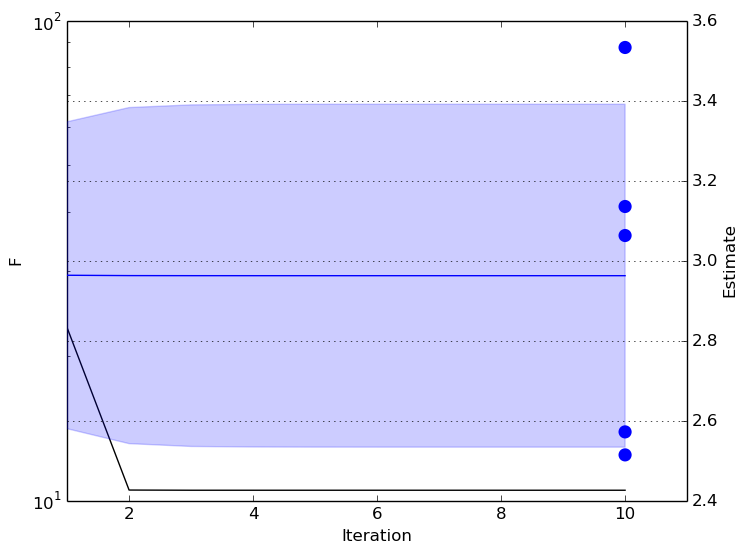

In [12]:
# Plot free energy to check for convergence
plot(1:n_its, F, color="black")
grid("on")
xlabel("Iteration")
ylabel("F")

# Plot estimated distribution
PyPlot.plt[:twinx]()
plot(1:n_its, m_est, color="blue")
fill_between(1:n_its, m_est-sqrt(1.0./w_est), m_est+sqrt(1.0./w_est), color="blue", alpha=0.2)
ylabel("Estimate")

# Plot samples
scatter(n_its*ones(n), y, color="blue", linewidth=5)

xlim(0.0, n_its+1)
;

In [11]:
# Inspect the results
println("\n----- Estimates after $(n_its) VMP updates -----")
println("Mean estimate: $(round(mean(marginals[:m]),2)), with variance $(round(var(marginals[:m]),2))")
println("Precision estimate: $(round(mean(marginals[:w]),2)), with variance $(round(var(marginals[:w]),2))")


----- Estimates after 10 VMP updates -----
Mean estimate: 2.96, with variance 0.04
Precision estimate: 5.44, with variance 11.8
